<a href="https://colab.research.google.com/github/sherlockofuniverse/Cosmic-Dust/blob/main/Searching_for_Cosmic_Dust_Sources_G54_1_%2B_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Photutils**

In [1]:
pip install photutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 826 kB 5.3 MB/s 


**Initialising Required Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm, Normalize
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.utils.data import get_pkg_data_filename
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus
from photutils.aperture import aperture_photometry
from tabulate import tabulate
import warnings

**Setting Up SNR Aperture and Annulus Coordinates**

In [3]:
#setting up SNR (G54) coordinates
SNR_ra = 292.6184               #Rho et al dust mass aperture centre
SNR_dec = 18.8685
SNR_dust_size = 90./(60*60)     #Rho et al 2018

#setting up pulsar coordinates
pulsar_ra = 292.6254
pulsar_dec = 18.8706
pulsar_size = 0.0015

#setting up annulus coordinates
annulus_ra = 292.6184 
annulus_dec = 18.8685 
annulus_size = 105/(60*60)
annulus_radius_arcsec = 105

**Dataset Selection**

In [14]:
warnings.filterwarnings("ignore")
#select reuired dataset
#run = '20-90K'
#run = '15-60K'
run = '20-90K no_870'

if run == '20-90K':
    datapath='/content/G54_tdenscube.fits'
    headpath='/content/G54_sigtdenscube.fits'
    name = '20-90'
elif run == '20-90K no_870':
    datapath='/content/G54_tdenscube_wo_870.fits'
    headpath='/content/G54_sigtdenscube_wo_870.fits'
    name='20-90_no870'

hdu = fits.open('/content/G54_tdenscube.fits')[0]

radio_hdu = fits.open('/content/G54_VLA_collapsed.fits')[0]

**Setting Up Arrays, Defining Variables and Loading in Data**

In [15]:
#set up like this in case of more betas
#betas=np.array([1.5,1.75,2.00,2.25])
betas=np.array([2.0])

#set up empty arrays for total masses
n_arrays = len(betas)
print('no of beta values we are looping over',n_arrays)
MASSES=np.zeros(n_arrays)
MASSES_before_bkgsub=np.zeros(n_arrays)
M_ERRORS=np.zeros(n_arrays)

tempno=12

#set up empty arrays for each temp loop
SNRaperture_mass = np.zeros((n_arrays,tempno))
SNR_mass = np.zeros((n_arrays,tempno))
errors = np.zeros((n_arrays,tempno))

#background
annulus = np.zeros((n_arrays,tempno),dtype=object)
median_back = np.zeros((n_arrays,tempno))

#loading in data
dataA = fits.getdata(datapath)[0]
bigdata = np.array([dataA])             # set up like this in case of more betas
size_deg = 0.03

no of beta values we are looping over 1


**Temperature Information**

In [16]:
#need to change next two lines if temp range different
lowertemp = 20.       #15
highertemp = 90.      #60.

temp = np.logspace(np.log10(lowertemp), np.log10(highertemp), tempno)       # separates into the 12 bins
float_temp = ["{:.1f}".format(float(elem)) for elem in temp]                # make temp a float for latex table purposes
Final_SNR_mass_array = np.zeros(tempno)
SNR_aperture_mass_array = np.zeros(tempno)

**Aperture Photometry Setup**

In [17]:
#getting the aperture details
positions = SkyCoord(ra = [SNR_ra], dec = [SNR_dec], unit='deg')
aperture = SkyCircularAperture(positions, SNR_dust_size*u.deg)
annulus = SkyCircularAnnulus(positions, r_in = SNR_dust_size*u.deg, r_out = annulus_size*u.deg)

**Units Conversion**

In [18]:
def convert(mass):
          
  #input data
  m_h2 = (1.67e-27)*2                         #mass of hydrogen atom multiplied by 2, to get H2 mass
  D = 6.2e3                                   #distance to remnant 
  pixelsize = hdu.header['CDELT2']*60*60      #projected pixel size  

  #conversion equations
  val = mass*1e20                             #coverting from PPMAP units (10^20 NH2/cm2) to NH2/cm^2
  val = val/100                               #gas to dust ratio = 100
  val = val*m_h2                              #converting from NH2/cm^2 to kg/cm^2
  val = val/2e30                              #converting kg/cm^2 to solar mass/cm^2

  #now we have solar mass/cm^2 and to get solar mass/pixel, we need to work out size of pixel in cm2 which is done by small angle formula
  d_pc = pixelsize*D/206265                   #converting arcsec to pc
  d_cm = d_pc*3e18                            #converting pc to cm
  d_2 = d_cm**2                               #squaring the cm value
  val = val*d_2                               #converting solar mass/cm2 and to get solar mass/pixel
  val = val*1.8
  return val

**Aperture Photometry**

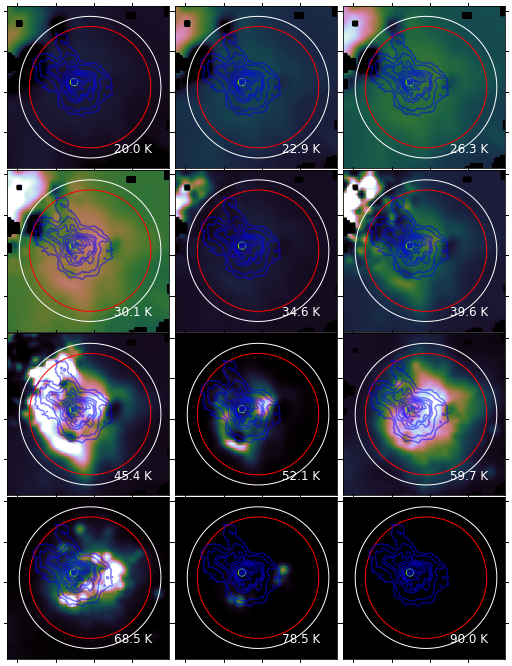

In [19]:
#setting up the loop that will be run for each beta,
# or once if beta is fixed
for i in range(len(betas)):

  sample = bigdata[i]
  hdr  = fits.getheader(headpath)
  wcs = WCS(fits.getheader(headpath)).sub(axes = 2)

  figure = plt.figure(figsize=(9,12))
  grid = gridspec.GridSpec(4,3)
  grid.update(wspace = 0.01, hspace = 0.01)

  ax = []
  lat = []
  lon = []

  #the loop that runs through each temperature map
  for t in range(tempno):

      #print(t)

      def SNR_photom(aperture, annulus, data):

        #converting sky to pixel apertures
        pix_large_aperture = annulus.to_pixel(wcs)
        pix_SNR_aperture = aperture.to_pixel(wcs)

        #SNR_photometry (sum the pixels) in SNR aperture
        phot_table = aperture_photometry(data, pix_SNR_aperture)
        SNR_aperture_mass = phot_table['aperture_sum']

        #STD of the SNR aperture pixels
        SNR_masks = pix_SNR_aperture.to_mask(method='center')
        SNR_data = SNR_masks[0].multiply(data)
        SNR_mask = SNR_masks[0].data
        SNR_data_1d = SNR_data[SNR_mask>0]
        SNR_data_1d.shape                                                           #this is the pixel values in the annulus only

        # background annulus statistics - need to mask out annulus area to get the pixel values
        # this is to get background level (using median sigma clipping)
        annulus_masks = pix_large_aperture.to_mask(method='center')
        annulus_data =  annulus_masks[0].multiply(data)
        mask = annulus_masks[0].data
        annulus_data_1d = annulus_data[mask>0]
        annulus_data_1d.shape                                                       #this is the pixel values in the annulus only

        noise_level = 5                                                             #sigma level for clipping data
        # need to ignore pixels with zeros since this affects stats
        mean_sigclip, median_sigclip, sigma_sigclip = \
        sigma_clipped_stats(annulus_data_1d,sigma=noise_level,cenfunc=np.median)    #median sig clip of pixels in annulus_data backgrround error

        backg_level = median_sigclip * pix_SNR_aperture.area                        #median value of background in SNR aperture  
        Final_SNR_mass = SNR_aperture_mass - backg_level                            #mass in SNR aperture minus background
        SNR_aperture_mass_array[t] = convert(SNR_aperture_mass)
        Final_SNR_mass_array[t] = convert(Final_SNR_mass)

        #number of pixels
        n_SNR_aperture = pix_SNR_aperture.area                                      #number of pixels in SNR aperture 
        n_bkg = pix_large_aperture.area                                             #number of pixels in SNR aperture

        #error analysis
        cal_error = 0.1*Final_SNR_mass #calibration error
        SNR_error = np.sqrt(n_SNR_aperture)*np.std(SNR_data_1d) 
        bkg_error = n_SNR_aperture*np.sqrt(np.std(annulus_data_1d)**2/n_bkg)

        total_error = np.sqrt(cal_error**2 + SNR_error**2 + bkg_error**2)
        return phot_table['aperture_sum'],Final_SNR_mass,total_error

  
      #plotting
      ax.append(plt.subplot(grid[t], projection=wcs))
      SNRaperture_mass[i,t], SNR_mass[i,t], errors[i,t]  = \
      SNR_photom(aperture,annulus,sample[t,:,:])
      
      #define some colour scales for each temp grid
      if run == '20-90K':
          if (t <= 1):
              norm = simple_norm(sample, 'sqrt', max_percent = 99.7, min_percent = 40)
          elif ((t > 1) and (t < 3)):
              norm = simple_norm(sample, 'sqrt', max_percent = 93, min_percent = 20)
          else:
              norm = simple_norm(sample, 'sqrt', max_percent = 90, min_percent = 40)
      else:
          if (t < 3):
              norm = simple_norm(sample, 'sqrt', max_percent = 90, min_percent = 40)
          elif (t >= 3) and (t < 4):
              norm = simple_norm(sample, 'sqrt', max_percent = 90, min_percent = 40)
              #norm = simple_norm(sample, 'power', power = 2, max_percent = 85, min_percent = 40)
          elif ((t >= 4) and (t < 7)):
              norm = simple_norm(sample, 'power', max_percent = 97, power = 2, min_percent = 0)
          elif ((t >= 7) and (t < 8)):
              norm = simple_norm(sample, 'power', power = 2, max_percent = 99.7, min_percent = 0)
          else:
              norm = simple_norm(sample, 'sqrt', max_percent = 99.9, min_percent = 0)
      
      #plot the data with colour scale
      img = ax[t].imshow(np.nan_to_num(sample[t,:,:]), cmap = 'cubehelix', origin = 'lower', norm = norm)
      ax[t].text(0.66,0.1, '{} K'.format(float_temp[t]), \
      transform = ax[t].transAxes, color='white', fontsize=12)       #adding temperature caption
      ax[t].contour(radio_hdu.data, transform = ax[t].get_transform(WCS(radio_hdu.header)), levels= [0.0003, 0.00050307, 0.00090921, 0.00111228, 0.00131535, 0.00151842, 0.00172149, 0.00192456], colors='blue', alpha=0.5)

      #adding the SNR aperture and annulus patches  
      Remnant = SphericalCircle((SNR_ra*u.deg, SNR_dec*u.deg), SNR_dust_size*u.deg, edgecolor = 'red', facecolor = 'none', transform = ax[t].get_transform('fk5'))
      ax[t].add_patch(Remnant)
      Annulus = SphericalCircle((annulus_ra*u.deg, annulus_dec*u.deg), annulus_size*u.deg, edgecolor = 'white', facecolor = 'none', transform = ax[t].get_transform('fk5'))
      ax[t].add_patch(Annulus)
      Pulsar = SphericalCircle((pulsar_ra*u.deg, pulsar_dec*u.deg), pulsar_size*u.deg, edgecolor = 'lawngreen', facecolor = 'none', transform = ax[t].get_transform('fk5'))
      ax[t].add_patch(Pulsar)  
      
      #plot formatting
      lon.append(ax[t].coords[0])
      lat.append(ax[t].coords[1])
      ax[t].set_xlim((25, 85))
      ax[t].set_ylim((25, 85))

      #hiding axes labels
      lon[t].set_ticklabel_visible(False)
      lat[t].set_ticklabel_visible(False)
      lon[t].set_ticks_visible(True)
      lat[t].set_ticks_visible(True)


**Dust Mass vs Temperature Curve**

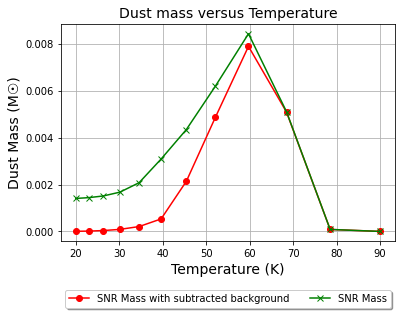

In [20]:
plt.plot(temp, Final_SNR_mass_array, color='red', marker='o')
plt.plot(temp, SNR_aperture_mass_array, color='green', marker='x')
plt.title('Dust mass versus Temperature', fontsize=14)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Dust Mass (M☉)', fontsize=14)
plt.legend(['SNR Mass with subtracted background', 'SNR Mass'], loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5)
plt.grid(True)
plt.show()

**Temperature - Mass Table**

In [21]:
ca = np.stack((temp, SNR_aperture_mass_array, Final_SNR_mass_array), axis=1)
col_names = ['Temperature', 'Aperture Mass', 'SNR Mass with subtracted background']
print(tabulate(ca, headers=col_names, tablefmt="grid"))

+---------------+-----------------+---------------------------------------+
|   Temperature |   Aperture Mass |   SNR Mass with subtracted background |
+===============+=================+=======================================+
|       20      |     0.0014083   |                           5.65652e-06 |
+---------------+-----------------+---------------------------------------+
|       22.9305 |     0.00144206  |                           1.46346e-05 |
+---------------+-----------------+---------------------------------------+
|       26.2903 |     0.00151313  |                           3.6545e-05  |
+---------------+-----------------+---------------------------------------+
|       30.1425 |     0.00167677  |                           8.79102e-05 |
+---------------+-----------------+---------------------------------------+
|       34.5591 |     0.00208026  |                           0.000207699 |
+---------------+-----------------+---------------------------------------+
|       39.6

**Final Mass and Error Calculations**

In [22]:
#this sums the total mass
MASSES_before_bkgsub[i]= np.sum(SNRaperture_mass[i,:][SNR_mass[i,:] > 0])
MASSES[i] = (np.sum(SNR_mass[i,:][SNR_mass[i,:] > 0]))     # net dust mass in aperture
M_ERRORS[i] = np.sqrt(np.sum((errors[i,:][SNR_mass[i,:] > 0]/SNR_mass[i,:][SNR_mass[i,:] > 0])**2.))*MASSES[i]

# to get dust mass in msolar you can write the above lines as
print("For beta = %.2f the mass within the SNR remnant is %.5e" % (betas[i], convert(MASSES_before_bkgsub[i])))
print("For beta = %.2f the mass after background subtraction is %.5e" % (betas[i], convert(MASSES[i])))
print('The error is', convert(M_ERRORS[i]))
print()

For beta = 2.00 the mass within the SNR remnant is 3.53941e-02
For beta = 2.00 the mass after background subtraction is 2.09718e-02
The error is 0.010759425721281721

